In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import os, sys
import random

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F

c:\Users\Admin\anaconda3\envs\mlasm2\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEED = 4321
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
main = pd.read_csv("data_labels_mainData.csv")
extra = pd.read_csv("data_labels_extraData.csv")

In [4]:
print(f'main file shape: {main.shape}')
print(f'extra file shape: {extra.shape}')

main file shape: (9896, 6)
extra file shape: (10384, 4)


In [5]:
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 4
EPOCHS = 100
NUM_CLASSES = len(main['cellType'].unique())
IN_CHANNELS = 3
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
EARLY_STOPPING = 3

# Supervised Model (VGG8)

In [6]:
from utils.MyDataset import MyDataset

train_imgs, val_imgs = train_test_split(main, test_size=0.2)

train_dataset = MyDataset(train_imgs, 'cellType')
val_dataset = MyDataset(val_imgs, 'cellType')
test_dataset = MyDataset(extra, '')

train_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = VAL_BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    num_workers = NUM_WORKERS,
    batch_size = 1,
    shuffle = True
)

In [7]:
from utils.trainer import train, val
from models.VGG import vgg8_bn

vgg8_bn = vgg8_bn(num_classes=NUM_CLASSES, in_channels=IN_CHANNELS)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg8_bn.parameters(), lr=LEARNING_RATE)

# Logs - Helpful for plotting after training finishes
vgg8_bn_train_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
vgg8_bn_val_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
vgg8_bn_best_val_acc = 0.0
prev_vgg8_bn_best_val_acc = 0.0
unchange_val_acc_count = 0

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train_loss, train_acc = train(vgg8_bn, train_loader, optimizer, loss_fn, NUM_CLASSES)
    vgg8_bn_train_logs['loss'].append(train_loss)
    vgg8_bn_train_logs['accuracy'].append(train_acc)
    vgg8_bn_train_logs['epoch'].append(epoch)
    
    prev_vgg8_bn_best_val_acc = vgg8_bn_best_val_acc
    val_loss, val_acc, vgg8_bn_best_val_acc = val(vgg8_bn, val_loader, loss_fn, NUM_CLASSES, vgg8_bn_best_val_acc, 'vgg8_bn_supervised_test2')
    vgg8_bn_val_logs['loss'].append(val_loss)
    vgg8_bn_val_logs['accuracy'].append(val_acc)
    vgg8_bn_val_logs['epoch'].append(epoch)
    
    # Check if best validation accuracy unchange in EARLY_STOPPING times, it will stop training
    if prev_vgg8_bn_best_val_acc == vgg8_bn_best_val_acc:
        unchange_val_acc_count += 1
    else:
        unchange_val_acc_count = 0
        
    if unchange_val_acc_count == EARLY_STOPPING:
        break
            
    

Epoch 1:


Val: 100%|██████████| 31/31 [00:13<00:00,  2.30batch/s, loss: 0.661793, accuracy: 70.252525% [1391/1980]]


New best validation accuracy: 70.252525, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 2:


Val: 100%|██████████| 31/31 [00:13<00:00,  2.27batch/s, loss: 0.532359, accuracy: 74.696968% [1479/1980]]


New best validation accuracy: 74.696968, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 3:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.59batch/s, loss: 0.474427, accuracy: 76.313133% [1511/1980]]


New best validation accuracy: 76.313133, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 4:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.61batch/s, loss: 0.718834, accuracy: 76.767677% [1520/1980]]


New best validation accuracy: 76.767677, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 5:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.65batch/s, loss: 0.634690, accuracy: 77.373741% [1532/1980]]


New best validation accuracy: 77.373741, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/vgg8_bn_supervised_test2_best.pth
Epoch 6:


Val: 100%|██████████| 31/31 [00:11<00:00,  2.62batch/s, loss: 0.557607, accuracy: 75.151512% [1488/1980]]


Epoch 7:


Val: 100%|██████████| 31/31 [00:13<00:00,  2.29batch/s, loss: 0.624260, accuracy: 77.070709% [1526/1980]]


Epoch 8:


Val: 100%|██████████| 31/31 [00:13<00:00,  2.24batch/s, loss: 0.739323, accuracy: 73.282829% [1451/1980]]


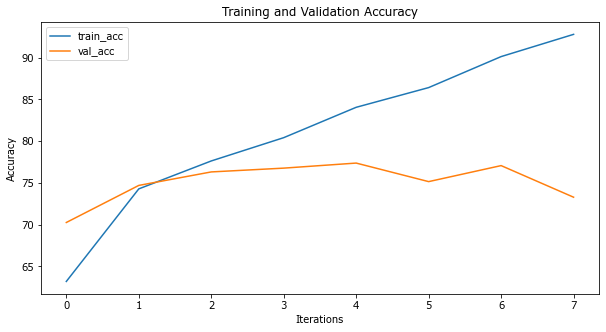

In [8]:
from utils.visualizer import visualize_accuracy, visualize_loss

visualize_accuracy(vgg8_bn_train_logs['accuracy'], vgg8_bn_val_logs['accuracy'])

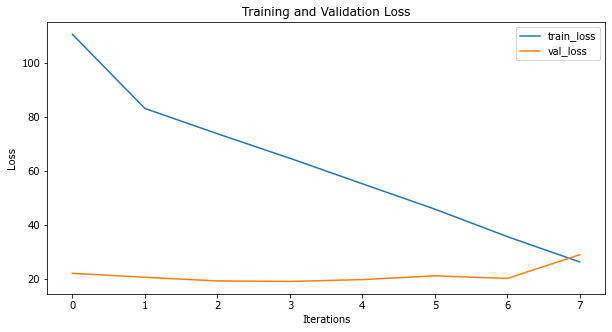

In [9]:
visualize_loss(vgg8_bn_train_logs['loss'], vgg8_bn_val_logs['loss'])

# Supervised Model (ResNet10)

In [6]:
from utils.MyDataset import MyDataset

train_imgs, val_imgs = train_test_split(main, test_size=0.2)

train_dataset = MyDataset(train_imgs, 'cellType')
val_dataset = MyDataset(val_imgs, 'cellType')
test_dataset = MyDataset(extra, '')

train_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = VAL_BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    num_workers = NUM_WORKERS,
    batch_size = 1,
    shuffle = True
)


In [7]:
from utils.trainer import train, val
from models.ResNet import resnet10

resnet10 = resnet10(num_classes=NUM_CLASSES, num_channels=IN_CHANNELS)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet10.parameters(), lr=LEARNING_RATE)

# Logs - Helpful for plotting after training finishes
resnet10_train_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
resnet10_val_logs = {'loss' : [], 'accuracy' : [], 'epoch' : []}
resnet10_best_val_acc = 0.0
prev_resnet10_best_val_acc = 0.0
EARLY_STOPPING = 3

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}:")
    train_loss, train_acc = train(resnet10, train_loader, optimizer, loss_fn, NUM_CLASSES)
    resnet10_train_logs['loss'].append(train_loss)
    resnet10_train_logs['accuracy'].append(train_acc)
    resnet10_train_logs['epoch'].append(epoch)
    
    prev_resnet10_best_val_acc = resnet10_best_val_acc
    val_loss, val_acc, resnet10_best_val_acc = val(resnet10, val_loader, loss_fn, NUM_CLASSES, resnet10_best_val_acc, 'resnet10_supervised_test2')
    resnet10_val_logs['loss'].append(val_loss)
    resnet10_val_logs['accuracy'].append(val_acc)
    resnet10_val_logs['epoch'].append(epoch)
    
    # Check if best validation accuracy unchange in EARLY_STOPPING times, it will stop training
    if prev_resnet10_best_val_acc == resnet10_best_val_acc:
        unchange_val_acc_count += 1
    else:
        unchange_val_acc_count = 0
        
    if unchange_val_acc_count == EARLY_STOPPING:
        break

Epoch 1:


Val: 100%|██████████| 31/31 [00:23<00:00,  1.34batch/s, loss: 0.755360, accuracy: 70.858589% [1403/1980]]


New best validation accuracy: 70.858589, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet10_supervised_test2_best.pth
Epoch 2:


Val: 100%|██████████| 31/31 [00:27<00:00,  1.12batch/s, loss: 0.571398, accuracy: 74.393936% [1473/1980]]


New best validation accuracy: 74.393936, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/resnet10_supervised_test2_best.pth
Epoch 3:


Val: 100%|██████████| 31/31 [00:23<00:00,  1.31batch/s, loss: 0.832386, accuracy: 72.323235% [1432/1980]]


Epoch 4:


Val: 100%|██████████| 31/31 [00:25<00:00,  1.21batch/s, loss: 0.940778, accuracy: 66.262627% [1312/1980]]


Epoch 5:


Val: 100%|██████████| 31/31 [00:23<00:00,  1.31batch/s, loss: 0.476597, accuracy: 72.979797% [1445/1980]]


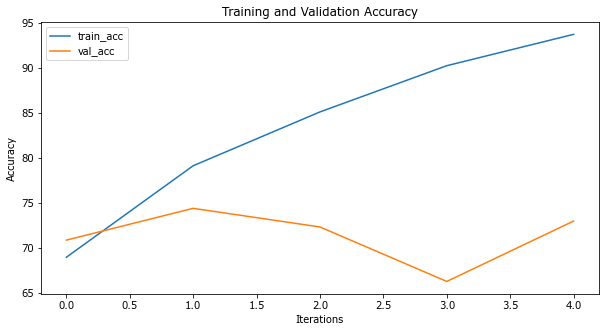

In [8]:
from utils.visualizer import visualize_accuracy, visualize_loss

visualize_accuracy(resnet10_train_logs['accuracy'], resnet10_val_logs['accuracy'])

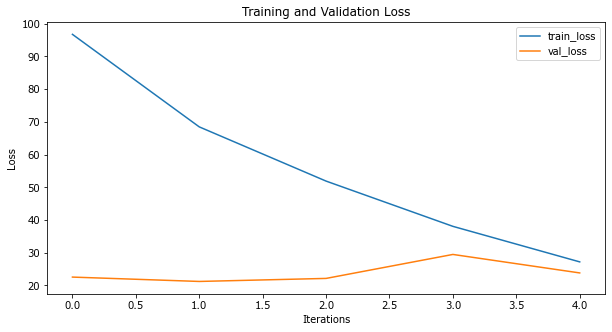

In [9]:
visualize_loss(resnet10_train_logs['loss'], resnet10_val_logs['loss'])

# Pseudo-Labeling 

In [10]:
LEARNING_RATE = 1e-4
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64
NUM_WORKERS = 4
EPOCHS = 10
NUM_CLASSES = len(main['cellType'].unique())
IN_CHANNELS = 3
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
EARLY_STOPPING = 3

In [13]:
from utils.trainer import test
from models.ResNet import resnet10
from models.VGG import vgg8_bn

loss_fn = nn.CrossEntropyLoss()

filepath = os.getcwd() + '/model_saved/'
model = None
saved = None
best_val_acc = 0
resnet10_best_val_acc = torch.load(filepath + 'resnet10_supervised_test2_best.pth')['best_val_acc']
vgg8_bn_best_val_acc = torch.load(filepath + 'vgg8_bn_supervised_test2_best.pth')['best_val_acc']

if resnet10_best_val_acc > vgg8_bn_best_val_acc:
    model = resnet10(num_classes=NUM_CLASSES, num_channels=IN_CHANNELS)
    model.load_state_dict(torch.load(filepath + 'resnet10_supervised_test2_best.pth')['model_state_dict'])
    best_val_acc = resnet10_best_val_acc
    print('Choosing model: resnet10')
else:
    model = vgg8_bn(num_classes=NUM_CLASSES, in_channels=IN_CHANNELS)  
    model.load_state_dict(torch.load(filepath + 'vgg8_bn_supervised_test2_best.pth')['model_state_dict'])
    best_val_acc = vgg8_bn_best_val_acc
    print('Choosing model: vgg8')


# if resnet10_best_val_acc > vgg8_bn_best_val_acc:
#     model_name += 'resnet10_supervised_test2_best.pth'
#     model = resnet10(num_classes=NUM_CLASSES, num_channels=IN_CHANNELS)
#     model.load_state_dict(torch.load(model_name)['model_state_dict'])
#     best_val_acc = torch.load(model_name)['best_val_acc']
# else:
#     model_name += 'vgg8_bn_supervised_test2_best.pth'
#     model = vgg8_bn(num_classes=NUM_CLASSES, in_channels=IN_CHANNELS)  
#     model.load_state_dict(torch.load(model_name)['model_state_dict'])
#     best_val_acc = torch.load(model_name)['best_val_acc']





Choosing model: vgg8


> Merged mainData with extraData (pseudo label) and feed to model again to learn

In [14]:
SEED = 6666
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [15]:
from utils.MyDataset import MyDataset

train_imgs, val_imgs = train_test_split(main, test_size=0.2)

train_dataset = MyDataset(train_imgs, 'cellType')
val_dataset = MyDataset(val_imgs, 'cellType')
test_dataset = MyDataset(extra, '')

train_loader = DataLoader(
    dataset = train_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = True
)

val_loader = DataLoader(
    dataset = val_dataset,
    num_workers = NUM_WORKERS,
    batch_size = VAL_BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_dataset,
    num_workers = NUM_WORKERS,
    batch_size = TRAIN_BATCH_SIZE,
    shuffle = True
)

In [31]:
from tqdm import tqdm

filepath = os.getcwd() + '/model_saved/'
DEVICE = torch.device('cuda') \
            if torch.cuda.is_available() \
            else torch.device('cpu')

T1 = 10
T2 = 70
af = 3

def alpha_weight(epoch):
    if epoch < T1:
        return 0.0
    elif epoch > T2:
        return af
    else:
         return ((epoch-T1) / (T2-T1))*af

def evaluate(model, test_loader, loss_criteria):
    model.eval()
    correct = 0 
    loss = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data = data.to(DEVICE)
            output = model(data)
            predicted = torch.max(output,1)[1]
            correct += (predicted == labels).sum()
            loss += loss_criteria(output, labels).item()

    return (float(correct)/len(test_loader)) *100, (loss/len(test_loader))
            
def semisup_train(
    model: nn.Module,
    train_loader: DataLoader,
    unlabled_loader: DataLoader,
    test_loader: DataLoader,
    optimizer: torch.optim,
    loss_criteria: torch.nn,
    best_val_acc: float,
    num_classes: int,
    model_name: str
):
    acc_scores = []
    unlabel = []
    pseudo_label = []
    step = 100

    alpha_log = []
    test_acc_log = []
    test_loss_log = []
    
    with tqdm(enumerate(unlabled_loader), unit = 'batch') as tepoch:
        for batch_idx, x_unlabeled in tepoch:
            x_unlabeled = x_unlabeled[0].to(DEVICE)
            model.eval()
            output_unlabeled = model(x_unlabeled)
            _, pseudo_labeled = torch.max(output_unlabeled, 1)
            model.train()  
            
            if (batch_idx < 3) and (epoch % 10 == 0):
                unlabel.append(x_unlabeled.to(DEVICE))
                pseudo_label.append(pseudo_labeled.to(DEVICE))
            
            # Now calculate the unlabeled loss using the pseudo label
            output = model(x_unlabeled)
            unlabeled_loss = alpha_weight(step) * loss_criteria(output, pseudo_labeled)   
            
            # Backpropogate
            optimizer.zero_grad()
            unlabeled_loss.backward()
            optimizer.step()
            
            
            # For every 50 batches train one epoch on labeled data 
            if batch_idx % 64 == 0:
                
                # Normal training procedure
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    X_batch = X_batch.to(DEVICE)
                    y_batch = y_batch.to(DEVICE)
                    output = model(X_batch)
                    labeled_loss = loss_criteria(output, y_batch)

                    optimizer.zero_grad()
                    labeled_loss.backward()
                    optimizer.step()
                
                # Now we increment step by 1
                step += 1
                
        test_acc, test_loss = evaluate(model, test_loader, loss_criteria)
        print(f'Alpha Weight : {alpha_weight(step):.5f} | Test Acc : {test_acc:.5f} | Test Loss : {test_loss:.3f} ')
        
        if test_acc > best_val_acc:
            best_val_acc = test_acc
            saved = {'best_val_acc': best_val_acc, 'model_state_dict': model.state_dict()}
            torch.save(saved, filepath + model_name + "_best.pth")
            print(f'New best validation accuracy: {best_val_acc:.6f}, add to {filepath + model_name + ""}_best.pth')
        
        model.train()
    return test_loss, test_acc, best_val_acc, alpha_weight(step)


In [32]:
# from utils.trainer import semisup_train

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Logs - Helpful for plotting after training finishes
pseudo_label_train_logs = {'loss' : [], 'accuracy' : [], 'epoch' : [], 'alpha': []}
pseudo_label_best_acc = best_val_acc
prev_pseudo_label_best_acc = best_val_acc
unchange_val_acc_count = 0

for epoch in range(1, 3 + 1):
    print(f"Epoch {epoch}:")
    prev_pseudo_label_best_acc = pseudo_label_best_acc
    train_loss, train_acc, pseudo_label_best_acc, alpha = semisup_train(model, train_loader, test_loader, val_loader, optimizer, loss_fn, pseudo_label_best_acc, NUM_CLASSES, 'pseudo_labels')
    pseudo_label_train_logs['loss'].append(train_loss)
    pseudo_label_train_logs['accuracy'].append(train_acc)
    pseudo_label_train_logs['epoch'].append(epoch)
    pseudo_label_train_logs['alpha'].append(alpha)
    
    # Check if best validation accuracy unchange in EARLY_STOPPING times, it will stop training
    if prev_pseudo_label_best_acc == pseudo_label_best_acc:
        unchange_val_acc_count += 1
    else:
        unchange_val_acc_count = 0
        
    if unchange_val_acc_count == EARLY_STOPPING:
        break

Epoch 1:


163batch [03:51,  1.42s/batch]


Alpha Weight : 0.01500 | Test Acc : 4429.03226 | Test Loss : 1.551 
New best validation accuracy: 4429.032258, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/pseudo_labels_best.pth
Epoch 2:


163batch [03:48,  1.40s/batch]


Alpha Weight : 0.01500 | Test Acc : 5170.96774 | Test Loss : 0.894 
New best validation accuracy: 5170.967742, add to d:\RMIT\MachineLearning\Asm\Asm2\Image_classification_data/model_saved/pseudo_labels_best.pth
Epoch 3:


163batch [03:35,  1.32s/batch]


Alpha Weight : 0.01500 | Test Acc : 4887.09677 | Test Loss : 1.440 


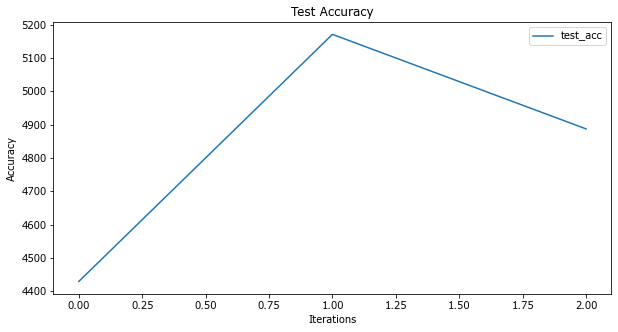

In [33]:
from utils.visualizer import visualize_test_acc, visualize_test_loss

visualize_test_acc(pseudo_label_train_logs['accuracy'])

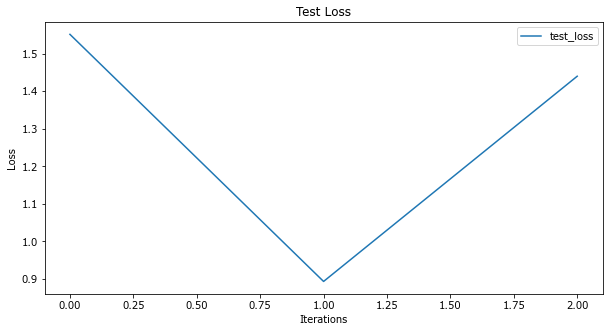

In [34]:
visualize_test_loss(pseudo_label_train_logs['loss'])